<a href="https://colab.research.google.com/github/irinaachikhmina/Triplexes/blob/main/2_01_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install biopython

In [ ]:
import os
import numpy as np
import pandas as pd
import sys
from collections import defaultdict

import Bio
from Bio import SeqIO

import scipy
import scipy.sparse as sps

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed, dump, load
from tqdm import trange
from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D, Input, LSTM
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.regularizers import L2

In [ ]:
# Sparse vector
!git clone --recurse-submodules https://github.com/Nazar1997/Sparse_vector
from Sparse_vector.sparse_vector import SparseVector

#Data loading

In [ ]:
DNA = {}
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
#chrom_names = [f'chr{i}' for i in list(range(1, 23, 2))]
length_genome = 0
for name in tqdm(chrom_names):
    DNA[name] = SeqIO.read('/content/drive/MyDrive/Triplexes/data/hg38/' 
                              + 'Homo_sapiens.GRCh38.dna.' 
                              + name[:3] 
                              + 'omosome.' 
                              + name[3:] 
                              + '.fa', 
                              'fasta')
    length_genome += len(DNA[name])
lens_of_chroms = {chrom: len(DNA[chrom]) for chrom in DNA}

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
States_features = [feature[:-4] for feature in os.listdir('/content/drive/MyDrive/Triplexes/data/states_sparse/') if feature[-3:] == 'pkl']
States = {feature: load(f'/content/drive/MyDrive/Triplexes/data/states_sparse/{feature}.pkl') 
         for feature in tqdm(States_features)}

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
Omics_features = [feature[:-4] for feature in os.listdir('/content/drive/MyDrive/Triplexes/data/omics_sparse/') if feature[-3:] == 'pkl']
Omics = {feature: load(f'/content/drive/MyDrive/Triplexes/data/omics_sparse/{feature}.pkl') 
         for feature in tqdm(Omics_features)}

  0%|          | 0/149 [00:00<?, ?it/s]

In [ ]:
Tad = load('/content/drive/MyDrive/Triplexes/data/tad_sparse/tad_tad.pkl')

In [ ]:
ints_in = pd.read_csv('/content/drive/MyDrive/Triplexes/data/ints_in.bed', header=None, sep='\t')
ints_in.columns = ['chr', 'start', 'end']
ints_out = pd.read_csv('/content/drive/MyDrive/Triplexes/data/ints_out1.bed', header=None, sep='\t')
ints_out.columns = ['chr', 'start', 'end']

In [ ]:
length = 34
width = 100
width_tad = 0
neg_portion = 1 #portions = [1, 5, 10, 20, 50, 70]

# Model

In [ ]:
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    if curr_session is not None:
        curr_session.close()
    tf.keras.backend.clear_session()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)
    return s

In [ ]:
def make_model_CNN():
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(length, features_n)))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
def make_model_RNN():
  model = Sequential()
  model.add(LSTM(32, activation='relu', input_shape=(length, features_n), recurrent_dropout = 0.25))
  model.add(Flatten())
  model.add(Dense(1))
  return model

In [ ]:
def make_model_RNN_CNN():
  model = Sequential()
  
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(length, features_n)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(LSTM(32, activation='relu', input_shape=(length, features_n), dropout = 0.25, recurrent_dropout = 0.3))

  model.add(Dense(1))
  return model

# DNA features only

## Data selection

In [ ]:
features_n = 4

In [ ]:
le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
def data_load(ints):
  data = []
  for i, interval in ints.iterrows():
    chrom = interval.chr
    begin = int(interval.start)
    end = int(interval.end)
    dna_OHE = le.transform(list(DNA[chrom][begin:end].upper()))
    data.append(np.hstack(dna_OHE).astype(np.float32))
  return data

In [ ]:
positives = data_load(ints_in)
positives = np.stack(positives)
print(positives.shape)

negatives = data_load(ints_out)
negatives = np.stack(negatives)
print(negatives.shape)

In [ ]:
X = np.concatenate([positives, negatives], axis=0)
y = [1 for i in range(len(positives))]
y.extend([0 for i in range(len(negatives))])
y = np.array(y)
print(X.shape)
print(y.shape)

(18038, 34, 4)
(18038,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14430, 34, 4) (3608, 34, 4) (14430,) (3608,)


## Train and test

In [ ]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 5s 7ms/step - loss: 0.1588 - auc: 0.9839 - precision: 0.9448 - recall: 0.9368 - accuracy: 0.9410 - val_loss: 0.1160 - val_auc: 0.9908 - val_precision: 0.9755 - val_recall: 0.9480 - val_accuracy: 0.9620 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 3s 7ms/step - loss: 0.0994 - auc: 0.9922 - precision: 0.9656 - recall: 0.9702 - accuracy: 0.9678 - val_loss: 0.1052 - val_auc: 0.9912 - val_precision: 0.9733 - val_recall: 0.9701 - val_accuracy: 0.9717 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 4s 8ms/step - loss: 0.0921 - auc: 0.9932 - precision: 0.9695 - recall: 0.9750 - accuracy: 0.9722 - val_loss: 0.0999 - val_auc: 0.9915 - val_precision: 0.9733 - val_recall: 0.9701 - val_accuracy: 0.9717 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 4s 9ms/step - loss: 0.0859 - auc: 0.9933 - precision: 0.9737 - recall: 0.9763 - accuracy: 0.9750 - val_loss: 0.1237 - val_auc: 0.9910 - val

# DNA + chromatin states

## Data selection

In [ ]:
features_n = 4 + len(States_features)
features_n

21

In [ ]:
le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
def data_load(ints):
  data = []
  for i, interval in ints.iterrows():
    chrom = interval.chr
    begin = int(interval.start)
    end = int(interval.end)
    dna_OHE = le.transform(list(DNA[chrom][begin:end].upper()))
    states_matr = []
    for feature in States_features:
      source = States[feature]
      if chrom in source:
        states_matr.append(source[chrom][begin:end])
      else:
        states_matr.append(np.zeros(end-begin))
    data_interval = np.hstack((dna_OHE, np.array(states_matr).T)).astype(np.float32)
    data.append(data_interval)
  return data

In [ ]:
positives = data_load(ints_in)
positives = np.stack(positives)
print(positives.shape)

negatives = data_load(ints_out)
negatives = np.stack(negatives)
print(negatives.shape)

(9019, 34, 21)
(9019, 34, 21)


In [ ]:
X = np.concatenate([positives, negatives], axis=0)
X.shape

(18038, 34, 21)

In [ ]:
y = [1 for i in range(len(positives))]
y.extend([0 for i in range(len(negatives))])
y = np.array(y)
y.shape

(18038,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14430, 34, 21) (3608, 34, 21) (14430,) (3608,)


## Train and test

In [ ]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 8s 13ms/step - loss: 0.1744 - auc: 0.9811 - precision: 0.9357 - recall: 0.9317 - accuracy: 0.9343 - val_loss: 0.1007 - val_auc: 0.9928 - val_precision: 0.9541 - val_recall: 0.9865 - val_accuracy: 0.9687 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 7s 16ms/step - loss: 0.1022 - auc: 0.9914 - precision: 0.9686 - recall: 0.9704 - accuracy: 0.9697 - val_loss: 0.1253 - val_auc: 0.9926 - val_precision: 0.9343 - val_recall: 0.9876 - val_accuracy: 0.9579 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 4s 9ms/step - loss: 0.0899 - auc: 0.9934 - precision: 0.9719 - recall: 0.9736 - accuracy: 0.9729 - val_loss: 0.0815 - val_auc: 0.9941 - val_precision: 0.9713 - val_recall: 0.9838 - val_accuracy: 0.9767 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 6s 12ms/step - loss: 0.0841 - auc: 0.9932 - precision: 0.9747 - recall: 0.9775 - accuracy: 0.9762 - val_loss: 0.0777 - val_auc: 0.9950 - 

# DNA + omics

## Data selection

In [ ]:
features_n = 4 + len(Omics_features)
features_n

153

In [ ]:
le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
def data_load_with_omics_wo_states(ints, width=width):
  data = []
  for i, interval in ints.iterrows():
    chrom = interval.chr
    begin = int(interval.start)
    end = int(interval.end)
    
    dna_OHE = le.transform(list(DNA[chrom][begin:end].upper()))
    
    omics_matr = []
    for feature in Omics_features:
      source = Omics[feature]
      if chrom in source:
        max_vals = np.zeros(end-begin)
        lag = int(width/2)
        vals = source[chrom][begin-lag:end+lag]
        for i in range(end-begin):
            max_vals[i] = np.max(vals[i:i+2*lag+1])
        omics_matr.append(max_vals)        
      else:
        omics_matr.append(np.zeros(end-begin))
    
    data_interval = np.hstack((dna_OHE, np.array(omics_matr).T/1000)).astype(np.float32)
    data.append(data_interval)
  return data

In [ ]:
positives = data_load_with_omics_wo_states(ints_in)
positives = np.stack(positives)
print(positives.shape)

negatives = data_load_with_omics_wo_states(ints_out)
negatives = np.stack(negatives)
print(negatives.shape)

(9019, 34, 153)
(9019, 34, 153)


In [ ]:
X = np.concatenate([positives, negatives], axis=0)
X.shape

(18038, 34, 153)

In [ ]:
y = [1 for i in range(len(positives))]
y.extend([0 for i in range(len(negatives))])
y = np.array(y)
y.shape

(18038,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14430, 34, 153) (3608, 34, 153) (14430,) (3608,)


## Train and test

In [ ]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 9s 16ms/step - loss: 0.2075 - auc: 0.9742 - precision: 0.9264 - recall: 0.9089 - accuracy: 0.9188 - val_loss: 0.0878 - val_auc: 0.9931 - val_precision: 0.9736 - val_recall: 0.9789 - val_accuracy: 0.9756 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 5s 12ms/step - loss: 0.0989 - auc: 0.9925 - precision: 0.9670 - recall: 0.9736 - accuracy: 0.9704 - val_loss: 0.0984 - val_auc: 0.9941 - val_precision: 0.9768 - val_recall: 0.9578 - val_accuracy: 0.9667 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 7s 16ms/step - loss: 0.0905 - auc: 0.9933 - precision: 0.9686 - recall: 0.9750 - accuracy: 0.9719 - val_loss: 0.0899 - val_auc: 0.9937 - val_precision: 0.9706 - val_recall: 0.9827 - val_accuracy: 0.9759 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 5s 12ms/step - loss: 0.0806 - auc: 0.9940 - precision: 0.9724 - recall: 0.9789 - accuracy: 0.9757 - val_loss: 0.0897 - val_auc: 0.9929 -

# DNA + chromatin states + omics

## Data selection

In [ ]:
features_n = 4 + len(States_features) + len(Omics_features)
features_n

170

In [ ]:
le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
def data_load_with_omics(ints, width=width):
  data = []
  for i, interval in ints.iterrows():
    chrom = interval.chr
    begin = int(interval.start)
    end = int(interval.end)
    
    dna_OHE = le.transform(list(DNA[chrom][begin:end].upper()))
    
    states_matr = []
    for feature in States_features:
      source = States[feature]
      if chrom in source:
        states_matr.append(source[chrom][begin:end])
      else:
        states_matr.append(np.zeros(end-begin))
    
    omics_matr = []
    for feature in Omics_features:
      source = Omics[feature]
      if chrom in source:
        max_vals = np.zeros(end-begin)
        lag = int(width/2)
        vals = source[chrom][begin-lag:end+lag]
        for i in range(end-begin):
            max_vals[i] = np.max(vals[i:i+2*lag+1])
        omics_matr.append(max_vals)        
      else:
        omics_matr.append(np.zeros(end-begin))
    
    data_interval = np.hstack((dna_OHE, np.array(states_matr).T, np.array(omics_matr).T/1000)).astype(np.float32)
    data.append(data_interval)
  return data

In [ ]:
positives = data_load_with_omics(ints_in)
positives = np.stack(positives)
print(positives.shape)

negatives = data_load_with_omics(ints_out)
negatives = np.stack(negatives)
print(negatives.shape)

(9019, 34, 170)
(9019, 34, 170)


In [ ]:
X = np.concatenate([positives, negatives], axis=0)
X.shape

(18038, 34, 170)

In [ ]:
y = [1 for i in range(len(positives))]
y.extend([0 for i in range(len(negatives))])
y = np.array(y)
y.shape

(18038,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14430, 34, 170) (3608, 34, 170) (14430,) (3608,)


## Train and test

In [ ]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 10s 18ms/step - loss: 0.2145 - auc: 0.9726 - precision: 0.9246 - recall: 0.9132 - accuracy: 0.9190 - val_loss: 0.0888 - val_auc: 0.9938 - val_precision: 0.9707 - val_recall: 0.9712 - val_accuracy: 0.9715 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 6s 12ms/step - loss: 0.1069 - auc: 0.9908 - precision: 0.9665 - recall: 0.9681 - accuracy: 0.9672 - val_loss: 0.0824 - val_auc: 0.9943 - val_precision: 0.9715 - val_recall: 0.9814 - val_accuracy: 0.9767 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 7s 16ms/step - loss: 0.0860 - auc: 0.9938 - precision: 0.9709 - recall: 0.9776 - accuracy: 0.9741 - val_loss: 0.0835 - val_auc: 0.9944 - val_precision: 0.9784 - val_recall: 0.9712 - val_accuracy: 0.9753 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 5s 12ms/step - loss: 0.0804 - auc: 0.9942 - precision: 0.9725 - recall: 0.9796 - accuracy: 0.9758 - val_loss: 0.0739 - val_auc: 0.9948 

# DNA + chromatin states + omics + tad

## Data splitting

In [ ]:
features_n = 4 + len(States_features) + len(Omics_features) + 1
features_n

171

In [ ]:
le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
def data_load_with_omics(ints, width=width, width_tad=width_tad):
  data = []
  for i, interval in ints.iterrows():
    chrom = interval.chr
    begin = int(interval.start)
    end = int(interval.end)
    
    dna_OHE = le.transform(list(DNA[chrom][begin:end].upper()))
    
    states_matr = []
    for feature in States_features:
      source = States[feature]
      if chrom in source:
        states_matr.append(source[chrom][begin:end])
      else:
        states_matr.append(np.zeros(end-begin))
    
    omics_matr = []
    for feature in Omics_features:
      source = Omics[feature]
      if chrom in source:
        max_vals = np.zeros(end-begin)
        lag = int(width/2)
        vals = source[chrom][begin-lag:end+lag]
        for i in range(end-begin):
            max_vals[i] = np.max(vals[i:i+2*lag+1])
        omics_matr.append(max_vals)        
      else:
        omics_matr.append(np.zeros(end-begin))
    
    tad = []
    if chrom in Tad:
      max_vals = np.zeros(end-begin)
      lag = int(width_tad/2)
      vals = Tad[chrom][begin-lag:end+lag]
      for i in range(end-begin):
          max_vals[i] = np.max(vals[i:i+2*lag+1])
      tad.append(max_vals)        
    else:
      tad.append(np.zeros(end-begin))
    
    data_interval = np.hstack((dna_OHE, np.array(states_matr).T, np.array(omics_matr).T/1000, np.array(tad).T)).astype(np.float32)
    data.append(data_interval)
  return data

In [ ]:
positives = data_load_with_omics(ints_in)
positives = np.stack(positives)
print(positives.shape)

negatives = data_load_with_omics(ints_out)
negatives = np.stack(negatives)
print(negatives.shape)

(9019, 34, 171)
(9019, 34, 171)


In [ ]:
X = np.concatenate([positives, negatives], axis=0)
X.shape

(18038, 34, 171)

In [ ]:
y = [1 for i in range(len(positives))]
y.extend([0 for i in range(len(negatives))])
y = np.array(y)
y.shape

(18038,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14430, 34, 171) (3608, 34, 171) (14430,) (3608,)


## CNN: train and test

In [ ]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 10s 17ms/step - loss: 0.2053 - auc: 0.9745 - precision: 0.9276 - recall: 0.9254 - accuracy: 0.9270 - val_loss: 0.1261 - val_auc: 0.9885 - val_precision: 0.9663 - val_recall: 0.9605 - val_accuracy: 0.9626 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 6s 13ms/step - loss: 0.1078 - auc: 0.9908 - precision: 0.9623 - recall: 0.9717 - accuracy: 0.9670 - val_loss: 0.0884 - val_auc: 0.9942 - val_precision: 0.9586 - val_recall: 0.9886 - val_accuracy: 0.9723 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 7s 16ms/step - loss: 0.0847 - auc: 0.9937 - precision: 0.9705 - recall: 0.9760 - accuracy: 0.9733 - val_loss: 0.0812 - val_auc: 0.9944 - val_precision: 0.9646 - val_recall: 0.9865 - val_accuracy: 0.9745 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 5s 12ms/step - loss: 0.0727 - auc: 0.9948 - precision: 0.9766 - recall: 0.9835 - accuracy: 0.9801 - val_loss: 0.0789 - val_auc: 0.9956 

## RNN: train and test

In [ ]:
model = make_model_RNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'RNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 25s 46ms/step - loss: 0.6745 - auc: 0.8272 - precision: 0.8427 - recall: 0.6356 - accuracy: 0.7579 - val_loss: 0.6551 - val_auc: 0.8544 - val_precision: 0.8252 - val_recall: 0.6844 - val_accuracy: 0.7719 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 22s 48ms/step - loss: 0.7344 - auc: 0.8966 - precision: 0.8991 - recall: 0.7877 - accuracy: 0.8493 - val_loss: 0.6409 - val_auc: 0.8252 - val_precision: 0.8869 - val_recall: 0.5618 - val_accuracy: 0.7475 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 20s 43ms/step - loss: 0.5707 - auc: 0.8468 - precision: 0.8996 - recall: 0.6492 - accuracy: 0.7879 - val_loss: 0.5694 - val_auc: 0.8669 - val_precision: 0.9355 - val_recall: 0.6407 - val_accuracy: 0.8002 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 19s 42ms/step - loss: 0.6176 - auc: 0.8663 - precision: 0.9095 - recall: 0.6792 - accuracy: 0.8053 - val_loss: 0.6309 - val_auc: 0.86

## RNN_CNN: train and test

In [ ]:
model = make_model_RNN_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 40

bst_model_path = 'RNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )

Epoch 1/40
451/451 [==============================] - 18s 32ms/step - loss: 0.6541 - auc: 0.9039 - precision: 0.8874 - recall: 0.7846 - accuracy: 0.8431 - val_loss: 0.5038 - val_auc: 0.9440 - val_precision: 0.9286 - val_recall: 0.8667 - val_accuracy: 0.8986 - lr: 0.0050
Epoch 2/40
451/451 [==============================] - 14s 31ms/step - loss: 0.8458 - auc: 0.8966 - precision: 0.8843 - recall: 0.7908 - accuracy: 0.8442 - val_loss: 0.5501 - val_auc: 0.9363 - val_precision: 0.9298 - val_recall: 0.7881 - val_accuracy: 0.8623 - lr: 0.0045
Epoch 3/40
451/451 [==============================] - 14s 30ms/step - loss: 0.8406 - auc: 0.9089 - precision: 0.8708 - recall: 0.8308 - accuracy: 0.8543 - val_loss: 0.4380 - val_auc: 0.9548 - val_precision: 0.9352 - val_recall: 0.8990 - val_accuracy: 0.9171 - lr: 0.0041
Epoch 4/40
451/451 [==============================] - 14s 31ms/step - loss: 0.6203 - auc: 0.8903 - precision: 0.9187 - recall: 0.7329 - accuracy: 0.8347 - val_loss: 0.5425 - val_auc: 0.87

# Features importance

https://www.nature.com/articles/s41467-022-31384-3#citeas

In [ ]:
! pip install shap

In [ ]:
import shap

#### Indexes

In [ ]:
indx_pos_test = np.where(y_test == 1)
indx_pos_train = np.where(y_train == 1)
indx_neg_test = np.where(y_test == 0)
indx_neg_train = np.where(y_train == 0)

## Shap with 5000 random background samples

In [ ]:
background = X_train[np.random.choice(X_train.shape[0], 5000, replace=False)]

In [ ]:
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test[indx_pos_test[0]])

In [ ]:
# feature attributions
attributions5000 = []
for i in range(len(shap_values[0][0][0])):
  attribution = []
  for sample in shap_values[0]:
    for position in sample:
      attribution.append(position[i])
  attributions5000.append((np.mean(attribution), np.std(attribution)))
  
attributions5000 = pd.DataFrame(attributions5000)
attributions5000.columns = ['mean', 'std']
attributions5000['factors'] = factors

attributions5000.nlargest(n=15, columns=['mean'])

,mean,std,factors
3,0.003181,0.004166,nuc_G
0,0.002956,0.003738,nuc_A
1,0.002782,0.004084,nuc_C
2,0.002164,0.003233,nuc_T
27,0.000550,0.001652,his_H3K27me3
13,0.000288,0.000837,cs_EnhBiv
4,0.000220,0.000711,cs_EnhA2
14,0.000211,0.000610,cs_TssBiv
31,0.000162,0.000519,his_H3K4me3
9,0.000144,0.000686,cs_TssA


In [ ]:
attributions5000.nsmallest(n=15, columns=['mean'])

,mean,std,factors
29,-0.000049,0.000346,his_H3K4me1
79,-0.000046,0.000467,tf_Epitope
62,-0.000017,0.000252,tf_CTCF
39,-0.000010,0.000147,pol_RNA
125,-0.000009,0.000163,tf_RELB
22,-0.000007,0.000119,his_H2A.Z
124,-0.000005,0.000123,tf_RELA
162,-0.000005,0.000121,tf_ZEB1
137,-0.000004,0.000077,tf_SP1
155,-0.000002,0.000090,tf_USF1


In [ ]:
attributions5000.to_csv('/content/drive/MyDrive/Triplexes/importance/attributions5000.scv')

Similar assessments have been made using 1000, 2500, 7500 background samples.

## Shap with X_train as background samples

In [ ]:
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test[indx_pos_test[0]])

In [ ]:
# feature attributions
attributions = []
for i in range(len(shap_values[0][0][0])):
  attribution = []
  for sample in shap_values[0]:
    for position in sample:
      attribution.append(position[i])
  attributions.append((np.mean(attribution), np.std(attribution)))
  
attributions = pd.DataFrame(attributions)
attributions.columns = ['mean', 'std']

factors = ['nuc_A', 'nuc_C', 'nuc_T', 'nuc_G']
factors.extend(States_features)
factors.extend(Omics_features)
factors.append('tad')
attributions['factors'] = factors

attributions.nlargest(n=15, columns=['mean'])

,mean,std,factors
0,0.003506,0.004392,nuc_A
3,0.003396,0.004271,nuc_G
2,0.002556,0.003843,nuc_T
1,0.002398,0.003799,nuc_C
27,0.000580,0.001819,his_H3K27me3
14,0.000297,0.000772,cs_TssBiv
13,0.000271,0.000750,cs_EnhBiv
31,0.000229,0.000731,his_H3K4me3
4,0.000211,0.000820,cs_EnhA2
9,0.000090,0.000472,cs_TssA


In [ ]:
attributions.nsmallest(n=15, columns=['mean'])

,mean,std,factors
29,-0.000078,0.000487,his_H3K4me1
79,-0.000049,0.000435,tf_Epitope
6,-0.000033,0.000335,cs_EnhWk
26,-0.000029,0.000245,his_H3K27ac
62,-0.000019,0.000305,tf_CTCF
39,-0.000010,0.000167,pol_RNA
16,-0.000008,0.000296,cs_ZNF-Rpts
18,-0.000007,0.000210,cs_Tx
22,-0.000006,0.000122,his_H2A.Z
84,-0.000006,0.000179,tf_GABPA


In [ ]:
attributions.to_csv('/content/drive/MyDrive/Triplexes/importance/attributionsTrain2.scv')

## Shap with X_test as background samples

In [ ]:
explainer = shap.DeepExplainer(model, X_test)
shap_values = explainer.shap_values(X_test[indx_pos[0]])

In [ ]:
# feature attributions
attributions = []
for i in range(len(shap_values[0][0][0])):
  attribution = []
  for sample in shap_values[0]:
    for position in sample:
      attribution.append(position[i])
  attributions.append((np.mean(attribution), np.std(attribution)))
  
attributions = pd.DataFrame(attributions)
attributions.columns = ['mean', 'std']

factors = ['nuc_A', 'nuc_C', 'nuc_T', 'nuc_G']
factors.extend(States_features)
factors.extend(Omics_features)
factors.append('tad')
attributions['factors'] = factors

attributions.nlargest(n=15, columns=['mean'])

,mean,std,factors
3,0.003238,0.004438,nuc_G
0,0.003160,0.004125,nuc_A
1,0.002580,0.003965,nuc_C
2,0.002506,0.003991,nuc_T
27,0.000588,0.001916,his_H3K27me3
13,0.000309,0.000862,cs_EnhBiv
14,0.000258,0.000741,cs_TssBiv
31,0.000170,0.000571,his_H3K4me3
4,0.000133,0.000429,cs_EnhA2
9,0.000083,0.000355,cs_TssA


In [ ]:
attributions.nsmallest(n=15, columns=['mean'])

,mean,std,factors
29,-0.000085,0.000515,his_H3K4me1
125,-0.000026,0.000352,tf_RELB
6,-0.000020,0.000307,cs_EnhWk
142,-0.000010,0.000148,tf_STAG1
79,-0.000008,0.000123,tf_Epitope
35,-0.000007,0.000157,his_H3ac
33,-0.000004,0.000110,his_H3K9ac
118,-0.000004,0.000160,tf_PML
124,-0.000004,0.000134,tf_RELA
164,-0.000003,0.000101,tf_ZNF143


In [ ]:
attributions.to_csv('/content/drive/MyDrive/Triplexes/importance/attributions_Test_Test.scv')

## Shap with X_test as background samples, asssessing on X_train_pos

In [ ]:
explainer = shap.DeepExplainer(model, X_test)
shap_values = explainer.shap_values(X_train[indx_pos_train[0]])

In [ ]:
# feature attributions
attributions = []
for i in range(len(shap_values[0][0][0])):
  attribution = []
  for sample in shap_values[0]:
    for position in sample:
      attribution.append(position[i])
  attributions.append((np.mean(attribution), np.std(attribution)))

attributions = pd.DataFrame(attributions)
attributions.columns = ['mean', 'std']

factors = ['nuc_A', 'nuc_C', 'nuc_T', 'nuc_G']
factors.extend(States_features)
factors.extend(Omics_features)
factors.append('tad')
attributions['factors'] = factors

attributions.nlargest(n=15, columns=['mean'])

,mean,std,factors
0,0.003650,0.004245,nuc_A
3,0.002950,0.003610,nuc_G
1,0.002742,0.003981,nuc_C
2,0.002524,0.003437,nuc_T
27,0.000555,0.001735,his_H3K27me3
13,0.000272,0.000878,cs_EnhBiv
14,0.000235,0.000712,cs_TssBiv
4,0.000218,0.000688,cs_EnhA2
31,0.000163,0.000572,his_H3K4me3
9,0.000106,0.000472,cs_TssA


In [ ]:
attributions.nsmallest(n=15, columns=['mean'])

,mean,std,factors
29,-0.000048,0.000276,his_H3K4me1
79,-0.000023,0.000190,tf_Epitope
39,-0.000016,0.000140,pol_RNA
62,-0.000007,0.000358,tf_CTCF
120,-0.000005,0.000107,tf_RAD21
84,-0.000004,0.000176,tf_GABPA
35,-0.000004,0.000087,his_H3ac
60,-0.000004,0.000096,tf_CREB1
33,-0.000003,0.000069,his_H3K9ac
162,-0.000003,0.000076,tf_ZEB1


In [ ]:
attributions.to_csv('/content/drive/MyDrive/Triplexes/importance/attributions_Test_Train2.scv')

## Plot

In [ ]:
attributions = pd.read_csv('/content/drive/MyDrive/Triplexes/importance/attributionsTrain.scv')
attributions.drop('Unnamed: 0', axis='columns', inplace=True)
attributions.drop('std', axis='columns', inplace=True)

#without impact of genomic sequence
attributions['norm_mean'] = attributions['mean'] / max(attributions['mean'][4:])

pos_limit, neg_limit = 0.08, -0.00431
attributions_tab = attributions[(attributions['norm_mean'] > pos_limit) +
                                (attributions['norm_mean'] < neg_limit)][4:]
attributions_tab.sort_values('norm_mean', ascending=False, inplace=True)

#Delete non-reproducible in other shap runs
non_reproduc = [26, 62, 17, 39, 124, 22, 60, 133]
attributions_tab.drop(index=non_reproduc, inplace=True)

#Description
attributions_tab[['group','factor']] = attributions_tab['factors'].str.split('_',expand=True)

attributions_tab

,mean,factors,norm_mean,group,factor
27,0.000543,his_H3K27me3,1.000000,his,H3K27me3
14,0.000356,cs_TssBiv,0.656264,cs,TssBiv
13,0.000189,cs_EnhBiv,0.349174,cs,EnhBiv
4,0.000187,cs_EnhA2,0.344377,cs,EnhA2
31,0.000172,his_H3K4me3,0.317410,his,H3K4me3
10,0.000114,cs_ReprPCWk,0.210595,cs,ReprPCWk
9,0.000110,cs_TssA,0.201888,cs,TssA
5,0.000098,cs_TssFlnk,0.180628,cs,TssFlnk
11,0.000073,cs_EnhA1,0.135330,cs,EnhA1
109,0.000073,tf_NFKB2,0.133939,tf,NFKB2


In [ ]:
attributions_tab.drop(index=79, inplace=True)

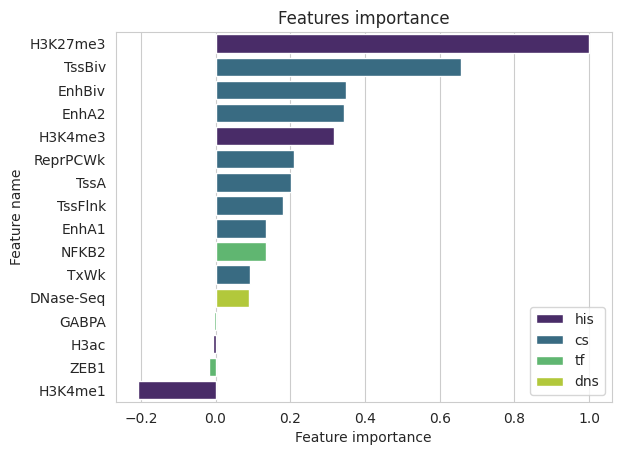

In [ ]:
sns.set_style("whitegrid")

colors = sns.color_palette("viridis", 10)
palette = {'his': colors[0], 
           'cs': colors[3],
           'tf': colors[-3], 
           'dns': colors[-1]}

ax = sns.barplot(x="norm_mean", y="factor", data=attributions_tab, 
                 hue=attributions_tab['group'], palette=palette,
                 dodge=False)
plt.legend(loc='lower right')
ax.set_xlabel("Feature importance")
ax.set_ylabel("Feature name")
plt.title("Features importance")

plt.show()